In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import colorsys
import scipy

In [4]:
image_folder = '../carseg_data/images/photo/with_segmentation/'
array_folder = '../carseg_data/arrays/'
new_array_folder = 'data/new_arrays_created/'

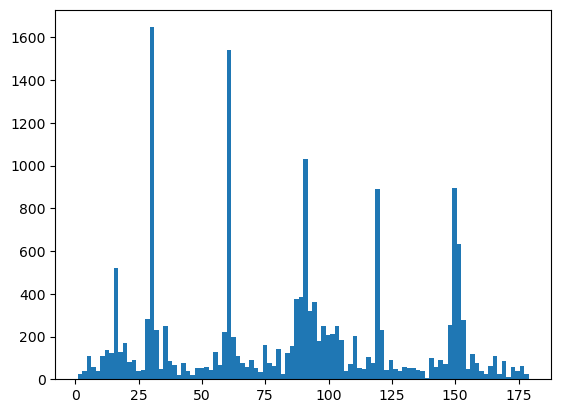

Peak H values:
30
[253 255   0]


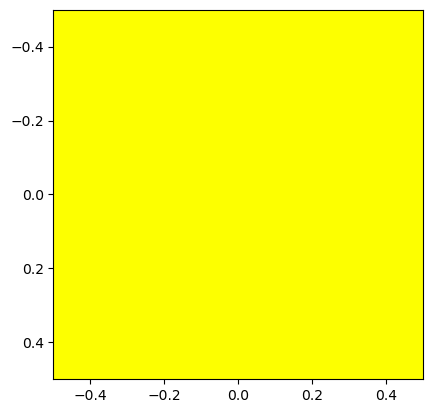

61
[  0 255  11]


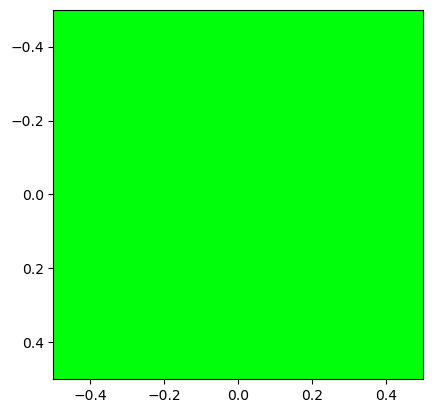

91
[  0 242 255]


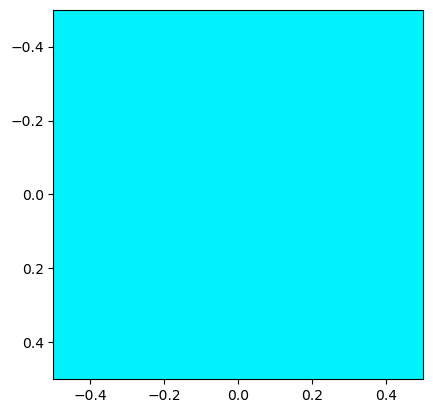

150
[255   0 247]


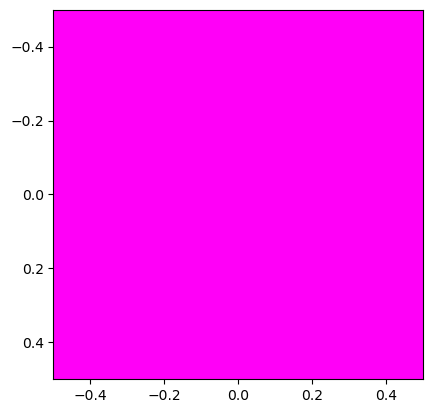

119
[  0   2 255]


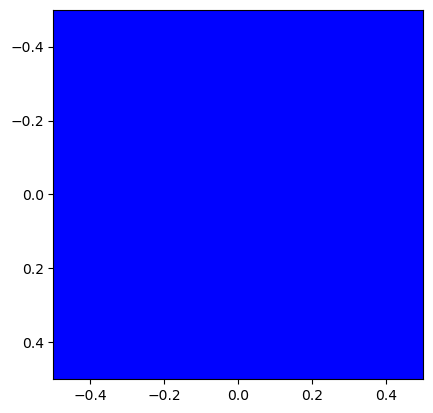

151
[255   0 239]


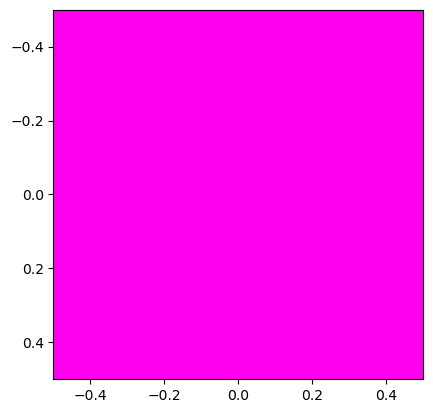

16
[255 136   0]


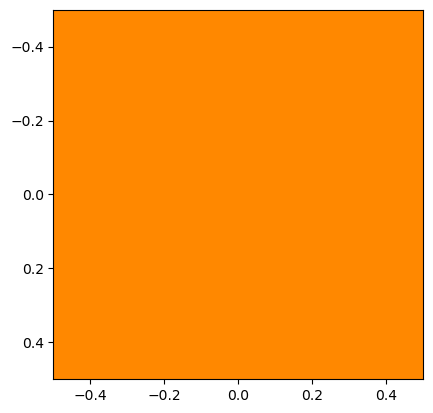

89
[  0 255 250]


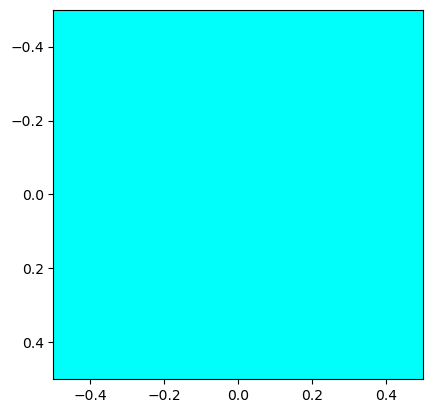

87
[  0 255 233]


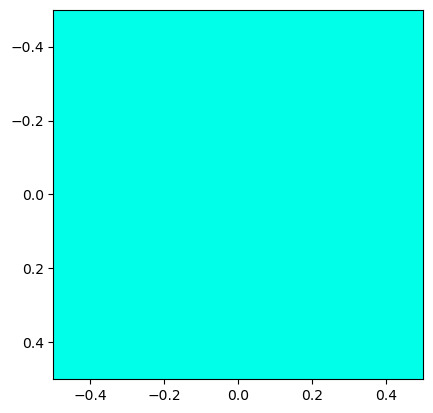

94
[  0 216 255]


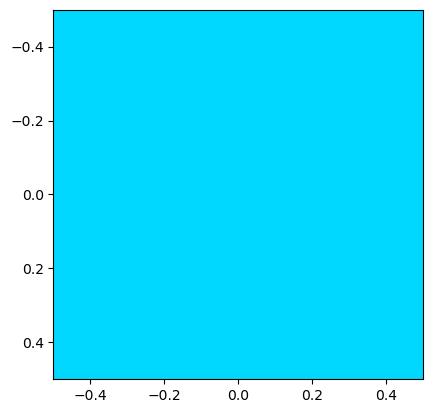

93
[  0 225 255]


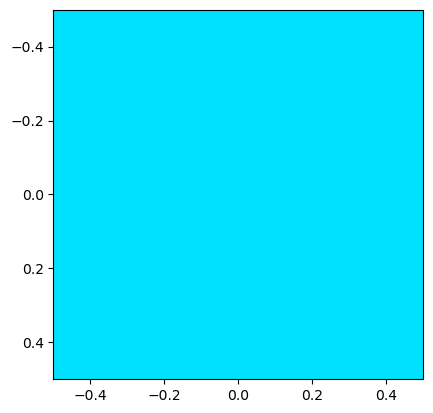

29
[255 247   0]


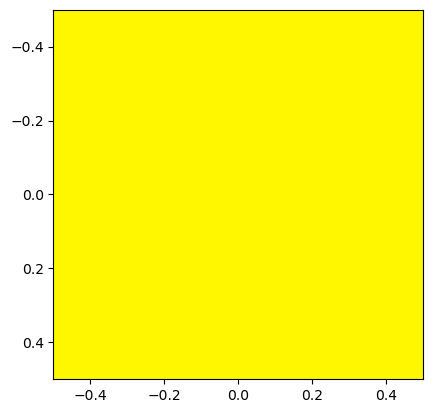

153
[255   0 222]


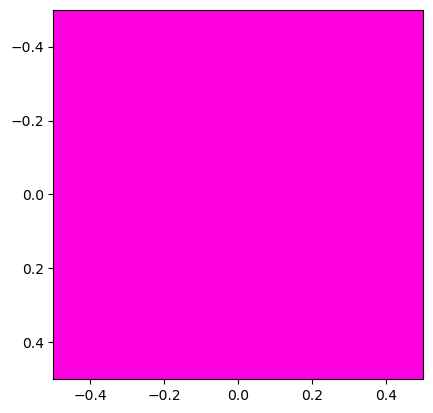

148
[245   0 255]


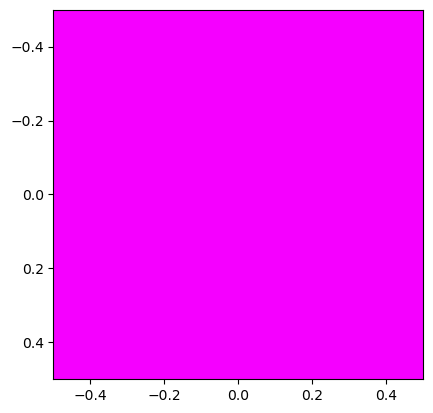

103
[  0 139 255]


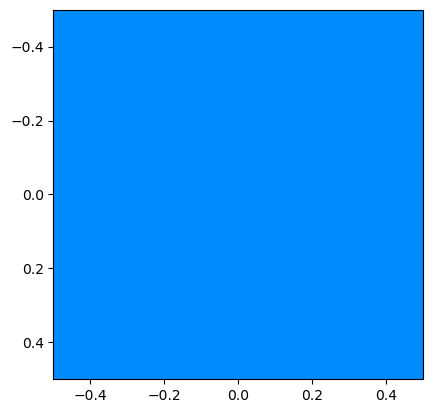

36
[202 255   0]


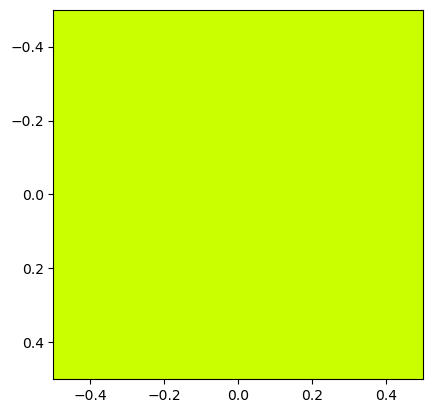

98
[  0 182 255]


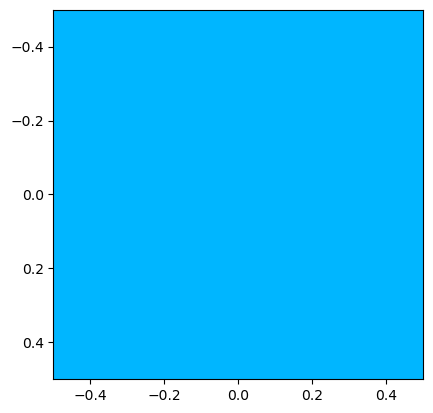

32
[236 255   0]


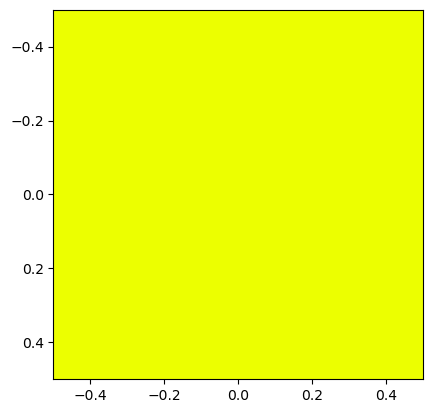

121
[ 14   0 255]


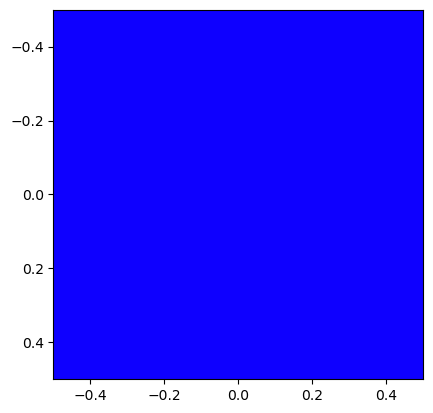

59
[  5 255   0]


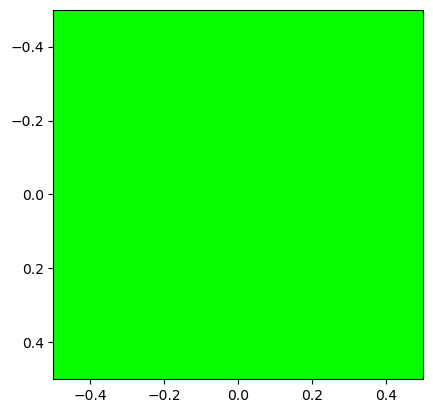

In [5]:
# Creating a histogram of the hue values of a predefined image and showing the colours of the peak hue values on the histogram (to connect them to the parts)

image_number = 1 # which image to use from the imageset
colors_to_show = 20 # how many colours to visualize based on the hue peaks

im = cv2.imread(os.path.join(image_folder, str(image_number).zfill(4)+'.jpg'))
arr = np.load(os.path.join(array_folder, 'photo_'+str(image_number).zfill(4)+'.npy'))

# makew the pixels labeled as background black
im[np.where(arr[...,-1]==0)] = [0, 0, 0]

cv2.imshow('image', im)
cv2.waitKey(0)
cv2.destroyAllWindows()

im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV) # convert the image to hsv

# plot the histogram with 100 bins
plt.hist(im[...,0].flatten()[im[...,0].flatten()!=0], bins = 100)
plt.show()

# calculate the number of elements in each bin
hist, bin_edges = np.histogram(im[...,0].flatten()[im[...,0].flatten()!=0], bins=100)

print('Peak H values:')
for i in range(1, colors_to_show+1):

    # determine the i'th most common hue value based on the histogram
    h = round((bin_edges[hist.argsort()[-i]] + bin_edges[hist.argsort()[-i]+1]) / 2)
    print(h)

    # plot a square of the color
    sample_color = (np.array(colorsys.hsv_to_rgb(h/179,1,1)) * 255).astype(int)
    print(sample_color)
    sample_im = np.empty((1,1,3))
    sample_im[...] = sample_color
    sample_im = sample_im.astype(int)
    plt.imshow(sample_im)
    plt.show()

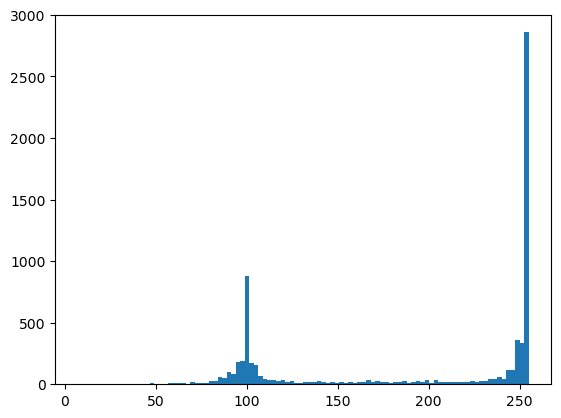

In [7]:
image_number = 48 # which image to use from the imageset

# use only the pixels at this hue value with this threshold
color_h = 60
color_h_threshold = 5

im = cv2.imread(os.path.join(image_folder, str(image_number).zfill(4)+'.jpg'))
im_hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

v_list = []

# Collect the value parameters from the images when the hue is close to the predefined threshold
# This way we will be able to differentiate between light / dark green and pink / purple
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        if im_hsv[i,j,0] < color_h-color_h_threshold or im_hsv[i,j,0] > color_h+color_h_threshold:
            im[i,j,:] = [0,0,0]
        else:
            v_list.append(im_hsv[i,j,2])

# Plot the values on a histogram
plt.hist(v_list, bins = 100)
plt.show()

cv2.imshow('image', im)
cv2.waitKey(0)
cv2.destroyAllWindows()

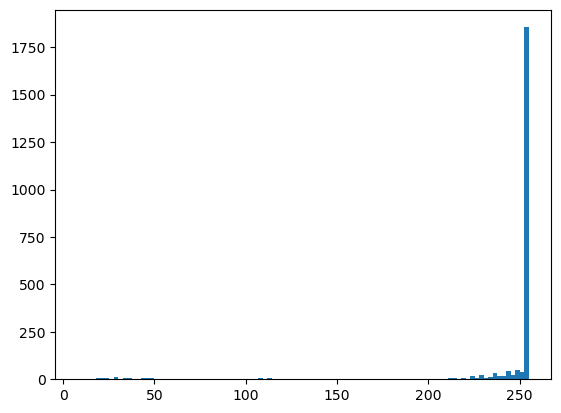

In [4]:
image_number = 1 # which image to use from the imageset
color_h = 60
color_h_threshold = 5

im = cv2.imread(os.path.join(image_folder, str(image_number).zfill(4)+'.jpg'))
im_hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

v_list = []

# Collect the saturation parameters from the images when the hue is close to the predefined threshold
# This way we will be able to eliminate almost all false detection from the rest of the car
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        if im_hsv[i,j,0] < color_h-color_h_threshold or im_hsv[i,j,0] > color_h+color_h_threshold:
            im[i,j,:] = [0,0,0]
        else:
            v_list.append(im_hsv[i,j,1])

# Plot the saturations on a histogram
plt.hist(v_list, bins = 100)
plt.show()

cv2.imshow('image', im)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
image_number = 12
color_h = 150
color_h_threshold = 5
color_v = 150
color_v_threshold = 20

im = cv2.imread(os.path.join(image_folder, str(image_number).zfill(4)+'.jpg'))
im_hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        if im_hsv[i,j,0] < color_h-color_h_threshold or im_hsv[i,j,0] > color_h+color_h_threshold or im_hsv[i,j,2] < color_v-color_v_threshold or im_hsv[i,j,2] > color_v+color_v_threshold:
            im[i,j,:] = [0,0,0]

cv2.imshow('image', im) 
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
image_list = os.listdir(image_folder)

# minimal contiguous area to be detected as a part
min_mask_area = 40

# go though all the jpg images
for image_name in image_list:
    im = cv2.imread(os.path.join(image_folder, image_name))

    image_number = int(image_name[:-4])
    arr = np.load(os.path.join(array_folder, 'photo_'+str(image_number).zfill(4)+'.npy'))

    im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

    # define the new array where we will store the results of our algorithm
    new_arr = arr.copy()
    new_arr[...,-1].fill(0)

    categories = [10,20,30,40,50,60,70,80]

    # create a separate mask for each category
    masks = np.zeros((len(categories), arr.shape[0], arr.shape[1]))

    # go through every pixel one by one
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):

            # if the pixel is not labeled as background
            if arr[i,j,-1] != 0:

                # create a label in one of the masks based on the colour of the pixel
                # if neither of these are true the pixel will be categorized as rest of the car
                if im[i,j,0] >= 10 and im[i,j,0] <= 20 and im[i,j,1] >= 180 and im[i,j,2] >= 100:
                    masks[0,i,j] = 1
                if im[i,j,0] >= 55 and im[i,j,0] <= 65 and im[i,j,1] >= 180 and im[i,j,2] >= 70 and im[i,j,2] <= 130:
                    masks[1,i,j] = 1
                if im[i,j,0] >= 25 and im[i,j,0] <= 35 and im[i,j,1] >= 180 and im[i,j,2] >= 100:
                    masks[2,i,j] = 1
                if im[i,j,0] >= 85 and im[i,j,0] <= 95 and im[i,j,1] >= 180 and im[i,j,2] >= 100:
                    masks[3,i,j] = 1
                if im[i,j,0] >= 145 and im[i,j,0] <= 155 and im[i,j,1] >= 180 and im[i,j,2] >= 100 and im[i,j,2] <= 180:
                    masks[4,i,j] = 1
                if im[i,j,0] >= 55 and im[i,j,0] <= 65 and im[i,j,1] >= 180 and im[i,j,2] >= 130:
                    masks[5,i,j] = 1
                if im[i,j,0] >= 115 and im[i,j,0] <= 125 and im[i,j,1] >= 180 and im[i,j,2] >= 100:
                    masks[6,i,j] = 1
                if im[i,j,0] >= 145 and im[i,j,0] <= 155 and im[i,j,1] >= 180 and im[i,j,2] > 180:
                    masks[7,i,j] = 1

    # go through each created mask
    for c_n, c in enumerate(categories):

        # count the contiguous area of the true areas in the current mask
        # in mask_areas every pixel will have the 0 or the size of the true area they are part of as their value
        mask_labeled, labels_n = scipy.ndimage.label(masks[c_n])
        mask_areas = np.zeros(masks[c_n].shape)
        for l in range(1,labels_n+1):
            mask_areas[mask_labeled==l] = np.sum(mask_labeled==l)
        masks[c_n,...][mask_areas<min_mask_area] = 0 # remove the areas smaller than the predefined size

        # apply a morphological close with a 5x5 circular kernel to fill the undetected pixels in bigger areas
        masks[c_n] = cv2.morphologyEx(masks[c_n], cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))

        # change the category labels to match the ones in the dataset from Deloitte
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                if masks[c_n,i,j]:
                    new_arr[i,j,-1] = c

    # add the labels for the rest of the car to the array
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[i,j,-1] != 0 and new_arr[i,j,-1] == 0:
                new_arr[i,j,-1] = 90

    # save the newly created array
    np.save(os.path.join(new_array_folder, 'photo_'+str(image_number).zfill(4)+'.npy'), new_arr)

In [17]:
range_low = 1
range_high = 30

for image_number in range(range_low,range_high+1):

    arr = np.load(os.path.join(os.path.join(new_array_folder, 'photo_'+str(image_number).zfill(4)+'.npy')))

    arr[np.where(arr[...,-1]==0)] = [0,0,0,0]
    arr[np.where(arr[...,-1]==10)] = [255,128,0,10]
    arr[np.where(arr[...,-1]==20)] = [0,100,0,20]
    arr[np.where(arr[...,-1]==30)] = [255,255,0,30]
    arr[np.where(arr[...,-1]==40)] = [0,255,255,40]
    arr[np.where(arr[...,-1]==50)] = [150,0,150,50]
    arr[np.where(arr[...,-1]==60)] = [0,255,0,60]
    arr[np.where(arr[...,-1]==70)] = [0,0,255,70]
    arr[np.where(arr[...,-1]==80)] = [255,0,255,80]

    cv2.imshow(str(image_number), cv2.cvtColor(arr[...,:-1], cv2.COLOR_RGB2BGR)) 
    cv2.waitKey(0)
    cv2.destroyAllWindows()